In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
%matplotlib inline

In [2]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

In [38]:
love_snippets.n_love_sents.sum()

3160

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
love_snippets.loc[[132, 2382]]

,transcript,url,sentences,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,57,12,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,109,15,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [4]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [5]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=True)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.02128322 0.01730776]
3 topics variance ratios: [0.02128322 0.01730629 0.01293195]
4 topics variance ratios: [0.02128323 0.01730666 0.01293405 0.0107154 ]
5 topics variance ratios: [0.02128322 0.01730625 0.01293759 0.01074004 0.00947261]


# The 2-Topic Result

In [6]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, person, just, feel, think, people, say, got, want, like, don, life, time, years


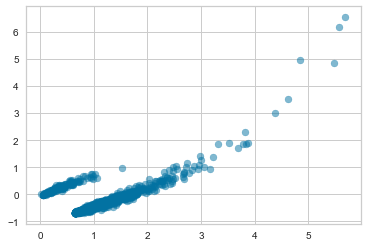

In [7]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

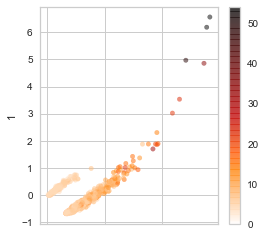

In [8]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents.astype({'n_love_sents':'int32'})+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

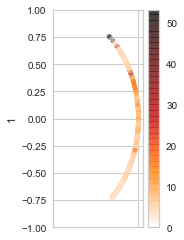

In [9]:
df = pd.DataFrame(normalize(cv_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

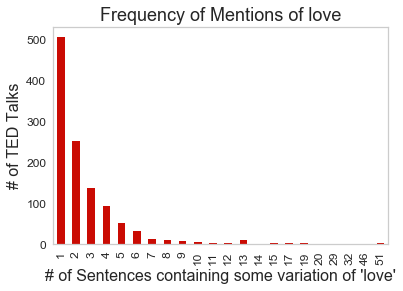

In [10]:
freq=pd.DataFrame(love_snippets.n_love_sents.value_counts()).sort_index()
ax = freq.plot.bar(title="Frequency of Mentions of love",\
                  legend=False, fontsize=12, color='r')
ax.title.set_size(18)
ax.set_xlabel("# of Sentences containing some variation of 'love'", fontsize=16)
ax.set_ylabel("# of TED Talks", fontsize=16)
ax.grid(False)
fig = ax.get_figure()
fig.savefig('./reports/figures/LoveMentionsInTEDTalks.svg',\
            format='svg', dpi=1200, transparent=True);

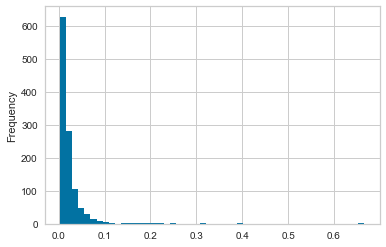

In [11]:
pct = love_snippets.n_love_sents/love_snippets.sentences
pct.plot.hist(bins=50);

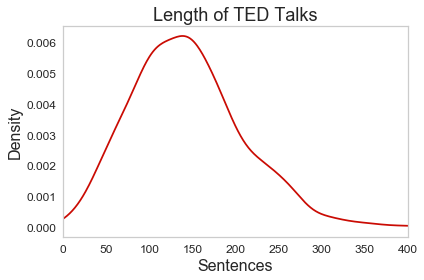

In [12]:
ax = love_snippets.sentences.plot.density(title="Length of TED Talks",\
                  legend=False, fontsize=12, color='r')
ax.title.set_size(18)
ax.set_xlabel("Sentences", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.set_xlim(0,400)
ax.grid(False)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('./reports/figures/TEDTalkLengthDensityPlot.svg',\
            format='svg', dpi=1200, transparent=True);

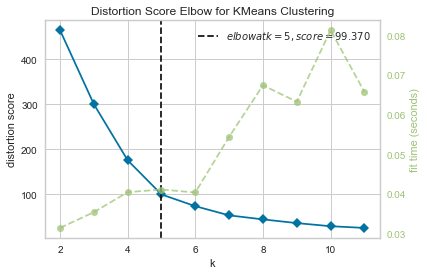

In [13]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(cv_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [14]:
visualizer.elbow_value_

5

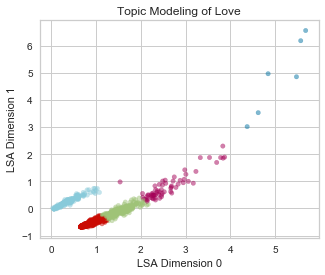

In [15]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [16]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 0.87313433 -0.54572792]
g [ 1.48143659 -0.1326146 ]
b [5.09312779 4.85567623]
c [0.38457919 0.25813266]
m [2.58769938 0.80594113]


In [17]:
love_snippets['cluster']= km.labels_
love_snippets.groupby(['cluster']).mean()

,sentences,n_love_sents
cluster,,
0,142.375209,1.725293
1,153.593960,3.761745
2,171.666667,36.500000
3,129.437500,1.227273
4,164.692308,8.830769


In [18]:
love_snippets[love_snippets['cluster']==2].love

23      But I want to start with my work on romantic l...
253     I and my colleagues Art Aron and Lucy Brown an...
302     He taught us that the richest and fullest live...
1966    I published this article in the New York Times...
2211    It's very common around the world, but we are ...
2276    OK, so today I want to talk about how we talk ...
Name: love, dtype: object

Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [19]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,cv_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.564937,0.170386,6.318635,1.071657,1.620171
1,0.294194,0.441434,6.571839,0.961197,1.889308
2,0.117420,0.852461,6.968646,0.962345,2.300706
3,0.636659,0.107128,6.265618,1.141423,1.554431
4,2.791935,2.062176,4.160295,2.804098,0.614630


Show the snippets from the 4 (euclidean distance) closest documents:

In [20]:
doc_topic = cv_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.87313433 -0.54572792] color= r
815 : [ 0.87827278 -0.5473392 ] His story is the following: He was recruited when he was 17, and sometime later, in his squadron, if you will, this beautiful girl was recruited, and they fell in love. But it turns out that love is very strictly forbidden in the lower ranks of the guerrilla, so their romance was discovered and they were separated. We'd love to help.
573 : [ 0.86793702 -0.5390215 ] Because probably some of the things that we love most are going to be also the things that can hurt us most.
990 : [ 0.86766799 -0.53909526] (Laughter)Now, I love this species despite the fact that it tried to kill us, and that's because this species in Madagascar, its closest relatives are 6,000 kilometers away, cavefishes in Australia.
626 : [ 0.88276728 -0.54271559] Mike deGruy was also invited, and he spoke with great passion about his love of the ocean, and he also talked to me about applying my approach to something he's been involv

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

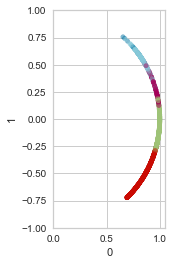

In [21]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [22]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.87313433 -0.54572792] color= r
815 : [ 0.87827278 -0.5473392 ] His story is the following: He was recruited when he was 17, and sometime later, in his squadron, if you will, this beautiful girl was recruited, and they fell in love. But it turns out that love is very strictly forbidden in the lower ranks of the guerrilla, so their romance was discovered and they were separated. We'd love to help.
641 : [ 0.94666739 -0.59350601] It's made into a grade where it's not usable for a nuclear weapon, but they love this stuff. Well, we're securing them, and it would be great if we could burn them, eat them up, and this reactor loves this stuff. So you have what's called the xenon pit, and so some of these fission products love neutrons. They love the neutrons that are going on and helping this reaction take place.
71 : [ 0.89771063 -0.5641003 ] In the Summer of Love, in 1967, two million people, children, died of smallpox.
535 : [ 0.88958833 -0.55276719] And he's just a

Now clustering on the 

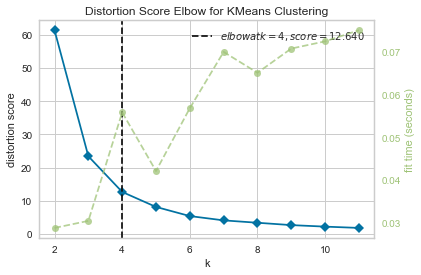

In [23]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

<IPython.core.display.Javascript object>


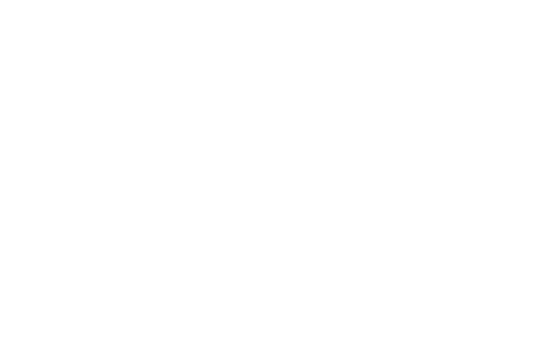

<IPython.core.display.Javascript object>


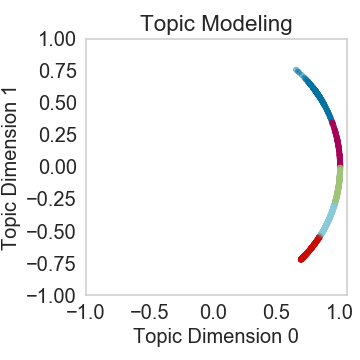

In [49]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

fig = plt.figure() 
ax = df.plot.scatter(x=0,y=1,figsize=(4,4), c=col, alpha = 0.5,title='Topic Modeling',\
                     fontsize=16);
ax.title.set_size(18)
ax.set_xlabel("Topic Dimension 0", fontsize=16)
ax.set_ylabel("Topic Dimension 1", fontsize=16)
ax.grid(False)
fig = ax.get_figure()
plt.tight_layout()
plt.axis([-1,1.05,-1,1]);
plt.savefig("reports/figures/CV_binary-lsa_2topic.svg",\
            format='svg', dpi=1200, transparent=True)

In [25]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.93564053 -0.33851128] color= r
936 : [ 0.94035329 -0.34019948] And over the years, from year after year as I've visited them and they've visited me, I get to gather with them and I sing and we write and we love it, because it reminds us that we're not just there to pursue science together; we're bonded through a shared humanity.
326 : [ 0.94024366 -0.34050237] Actually, I fell in love with the ocean when I was a little boy, when I was about eight or nine. I saw grottoes and secret gardens and places I'd love to hide as a kid, if I could only breathe underwater. I love to draw the deep sea fish, because they are so ugly, but beautiful in their own way. This is what I love about comic strips, you know.
1041 : [ 0.94058311 -0.33956355] The news loved it. Better than that, my theorist colleagues — I love my theorist colleagues — my theorist colleagues wrote 500 papers about this little bump.
7 : [ 0.939984   -0.34121851] I just, this is why I love what Michael does

# The 3-Topic Result

In [26]:
display_topics(cv_lsa[1], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, just, person, feel, think, people, say, want, got, like, don, time, life, years

Topic  2
love, think, want, study, ve, thinking, lot, brain, romantic, little, work, single, know, drive


In [27]:
cv_doc_topic[1]

array([[ 1.33989855, -0.22943092, -0.65579065],
       [ 1.11048998, -0.37098424,  0.12218922],
       [ 0.78114611, -0.6180906 ,  0.19324561],
       ...,
       [ 0.74191759, -0.62435196,  0.15942119],
       [ 1.1303783 , -0.57181558,  0.16271059],
       [ 0.8737069 , -0.5778502 ,  0.0425365 ]])

In [28]:
from mpl_toolkits.mplot3d import Axes3D

In [29]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(cv_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

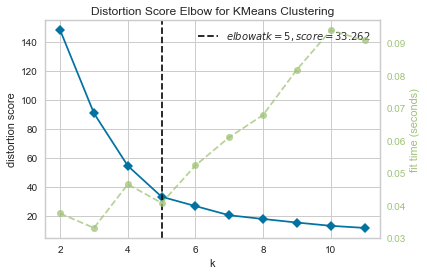

In [30]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [31]:
num_clusters = 4 #visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


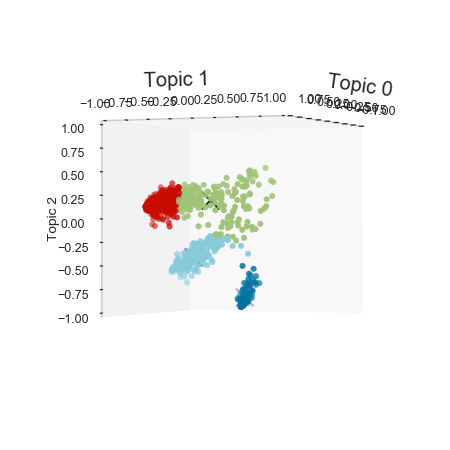

In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=200,c='k')
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [ ]:
doc_topic = cv_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

# The 4-Topic Result

In [50]:
display_topics(cv_lsa[2], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, just, person, think, feel, people, say, want, got, like, don, time, life, years

Topic  2
love, think, want, study, thinking, lot, brain, romantic, ve, work, little, single, right, start

Topic  3
loved, love, doing, idea, fell, great, instead, didn, version, laughter, make, real, experiences, generous


In [51]:
doc_topic = cv_doc_topic[2]
df = pd.DataFrame(normalize(cv_doc_topic[2]))

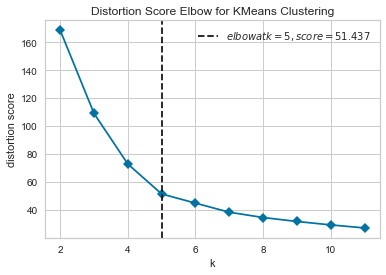

In [52]:
%matplotlib inline
fig, ax = plt.subplots()
km=KMeans()
visualizer = KElbowVisualizer(km, ax=ax, k=(2,12),metric='distortion',\
                              timings=False)  #,title='for KMeans Clustering')
visualizer.fit(df)                     # Fit the data to the visualizer
# fig.suptitle('Distortion Score Elbow', fontsize=18)
# ax.set_xlabel('k',fontsize=16)
# ax.set_ylabel('Distortion Score',fontsize=16)
visualizer.show(outpath='./reports/figures/cv_binary_lsa_4Elbow.svg',dpi=1200);                     # Finalize and render the figure

In [72]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


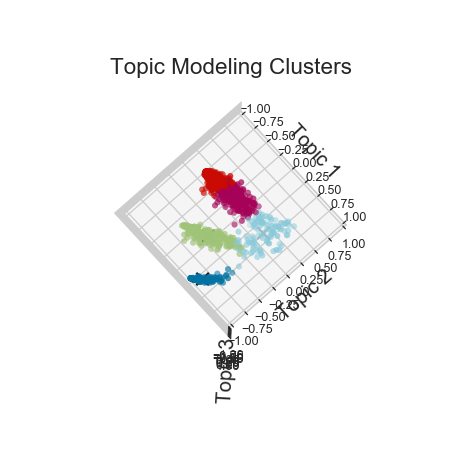

In [73]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) # .gca(projection='3d')
ax = fig.add_subplot(111, projection='3d',\
                     title="Topic Modeling Clusters")
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.title.set_size(18)
ax.set_xlabel('Topic 1', fontsize=16)
ax.set_ylabel('Topic 2', fontsize=16)
ax.set_zlabel('Topic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.view_init(elev=90, azim=-45)
ax.dist = 12
fig.show()
fig.savefig('./reports/figures/cv_binary-lsa_4topic.svg',\
            format='svg', dpi=1200, transparent=True);

<IPython.core.display.Javascript object>


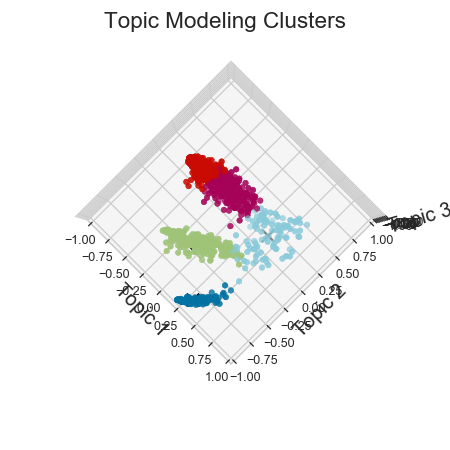

In [56]:
# Set up formatting for the movie files
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/Cellar/ffmpeg/4.2.1_2/bin/ffmpeg'
Writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Sean Davern'),\
                                bitrate=-1, extra_args=['-vcodec','libx264'])

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, title="Topic Modeling Clusters")
ax.title.set_size(18)
ax.set_xlabel('Topic 1', fontsize=16)
ax.set_ylabel('Topic 2', fontsize=16)
ax.set_zlabel('Topic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
# Create an init function and the animate functions.
# Both are explained in the tutorial:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/
# Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function.
def init():
    ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
    ax.scatter(df[1],df[2],df[3],c=col)
    ax.dist = 12
    return fig,

def animate(i):
    ax.view_init(elev=15+i, azim=-45)
    ax.dist = 12
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=75, interval=1, blit=True,
                               repeat=False)
# Save
anim.save('./reports/figures/cv_binary-lsa_animation.mp4',\
          writer = Writer, dpi=600)

In [57]:
doc_topic = cv_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.78404889 -0.57805835  0.15398473  0.07027781] color= r
1008 : [ 0.80104077 -0.57379812  0.15124537  0.0788305 ] So the Cas9 — I love to anthropomorphize — so the Cas9 is kind of this Pac-Man thing that wants to chew DNA, and the guide RNA is the leash that's keeping it out of the genome until it finds the exact spot where it matches.
665 : [ 0.78770627 -0.59493351  0.14952447  0.05670426] Let's say you're in love.
770 : [ 0.78164139 -0.60154028  0.15115953  0.06585454] I'd love to tell you that I didn't flinch, but I was terrified, and when my fear subsided, I became obsessed with finding out how this happened, how animal rights and environmental activists who have never injured anyone could become the FBI's number one domestic terrorism threat.
524 : [ 0.77660129 -0.60312779  0.1666042   0.07328269] It's an expression of love. It's an expression of beauty, it's how they say they love you.


Cluster centered at: [ 0.87912874 -0.06760069 -0.40251212  0.0546936 ]